<a href="https://colab.research.google.com/github/pumazzo/ML4HS-UC/blob/main/Notebook_7_1_ML4HS_UC2023_Integrated_Gradients_e_TracIn_Mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# xAI handOn based on the first one!

Slide for xAI and TracIn ([SLIDE](https://docs.google.com/presentation/d/1YkYls7ElSjxKW-HG2sMPlymSuKcLjBCtH77n8LVVNLA/edit?usp=sharing))


Jamborad for today ([BOARD](https://jamboard.google.com/d/1MAaDvaBTjy3RluS62r8mXKiOI6ZWDKc8Mn7BZap62eA/edit?usp=sharing))

[PAPER INTEGRATED GRADIENTS](https://arxiv.org/pdf/1703.01365.pdf)

[PAPER TRACIN](https://arxiv.org/pdf/2002.08484.pdf)

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# Set random seed for reproducibility
torch.manual_seed(42)

# Load the MNIST dataset and apply transformations
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0,), (1,))])

train = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

trainset, valiset = torch.utils.data.random_split(
        train, [50000, 10000], generator=torch.Generator().manual_seed(1))

# Create data loaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True,num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False)
valiloader = torch.utils.data.DataLoader(valiset, batch_size=128, shuffle=False)

In [12]:
len(trainset)

50000

In [13]:
# Define the neural network model
import torch.nn.functional as F
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        # Max pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # Fully connected layers
        self.fc1 = nn.Linear(64 * 3 * 3, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 10)
        # Dropout layer
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        #print(x.shape)
        # Flatten the tensor
        x = x.view(-1, 64 * 3 * 3)
        # Apply dropout
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x






In [14]:
model = Net()
from torchsummary import summary
if torch.cuda.is_available():
  summary(model.cuda(), input_size=(1,28,28))
else:
  summary(model, input_size=(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
         MaxPool2d-2           [-1, 32, 14, 14]               0
            Conv2d-3           [-1, 32, 14, 14]           9,248
         MaxPool2d-4             [-1, 32, 7, 7]               0
            Conv2d-5             [-1, 64, 7, 7]          18,496
         MaxPool2d-6             [-1, 64, 3, 3]               0
           Dropout-7                  [-1, 576]               0
            Linear-8                   [-1, 64]          36,928
           Dropout-9                   [-1, 64]               0
           Linear-10                   [-1, 64]           4,160
          Dropout-11                   [-1, 64]               0
           Linear-12                   [-1, 10]             650
Total params: 69,802
Trainable params: 69,802
Non-trainable params: 0
---------------------------------

# Lets create all the folders needed

In [15]:
import os
def CreateDir(path):
	# Create a directory if it does not exist
	success = os.path.exists(path)
	if not success:
		os.makedirs(path)
CreateDir("results")#
CreateDir("results/display")
CreateDir("results/preprocess")
#CreateDir("data")

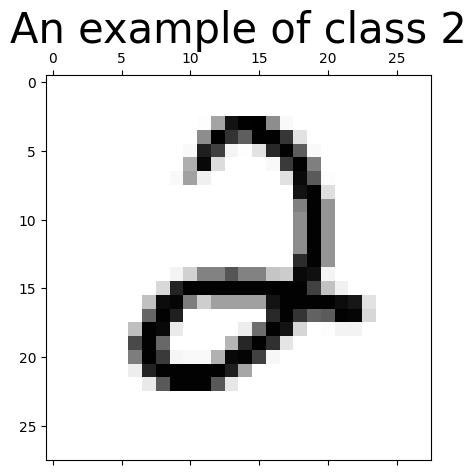

In [16]:
import matplotlib.pyplot as plt
to_plot = 10
def plot_example(trainset,to_plot):
  image = trainset[to_plot][0][0].detach().cpu().numpy()
  lab = trainset[to_plot][1]
  f,ax = plt.subplots(1,1,figsize=(5,5))
  ax.matshow(image,cmap="Greys")
  ax.set_title("An example of class {}".format(lab),fontsize=30)

plot_example(trainset,to_plot)

In [17]:


# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-2)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.90)

In [18]:
def accuracy(y_pred, y_true):
    """
    Calculates the accuracy of the predicted labels.

    Args:
        y_pred (torch.Tensor): predicted labels
        y_true (torch.Tensor): true labels

    Returns:
        float: accuracy score
    """
    # Get the predicted class by finding the index of the maximum value along axis 1
    y_pred = torch.argmax(y_pred, axis=1)
    #y_true = torch.argmax(y_true, axis=1)

    # Calculate the number of correctly classified examples
    correct = (y_pred == y_true).sum().item()

    # Calculate the total number of examples
    total = len(y_true)

    # Calculate the accuracy
    acc = correct / total

    return acc

In [19]:
# define device to use (cpu/gpu)
if torch.cuda.is_available():
  print('# of GPUs available: ', torch.cuda.device_count())
  print('First GPU type: ',torch.cuda.get_device_name(0))
device = ('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Computation device: {device}\n")

#device = "cpu"

model.to(device)

# of GPUs available:  1
First GPU type:  Tesla V100-SXM2-16GB
Computation device: cuda



Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=576, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)

In [20]:
# Define the number of epochs and the patience for early stopping
num_epochs = 20
patience = 10
TRAIN = 1

# Initialize the variables for tracking the best validation accuracy and the number of epochs since the best accuracy
best_val_acc = 0.0
epochs_since_best_val_acc = 0

train_curve=[]
val_curve=[]
lr_curve=[]

lr_ckp=[]
epc_ckp = []

if TRAIN:
  # Train loop
  for epoch in range(num_epochs):# the network train on all the elements
      if epoch == 0:
        optimizer.param_groups[0]['lr'] = 0.01

      if epoch == 10:
        optimizer.param_groups[0]['lr'] = 0.005

      if epoch == 15:
        optimizer.param_groups[0]['lr'] = 0.003


      if epoch > 20:
        scheduler.step()
      # Training
      model.train()
      tmp_loss = 0
      for batch_idx, (data, target) in enumerate(trainloader): # divide the problem in batches

          data = data.to(device)
          target = target.to(device)
          # Forward pass


          output = model(data)# output will be something [batch,4]
          loss = criterion(output, target)

          # Backward pass and optimization
          optimizer.zero_grad()# clear the previous gradients
          loss.backward()# compute gradient of loss
          optimizer.step()# update the weigths

          tmp_loss += loss.detach().cpu().numpy()



      lr_curve.append(optimizer.param_groups[0]['lr'])
      train_curve.append(tmp_loss/len(trainloader))
      # Validation
      model.eval() # the validation step do NOT change the parameters
      with torch.no_grad():
          val_acc = 0.0
          val_total = 0
          val_loss = 0
          for data, target in valiloader:
              data = data.to(device)
              target = target.to(device)
              output = model(data)
              val_loss += criterion(output, target).item()


              val_acc += accuracy(output, target)

          val_acc /=  len(valiloader)
          val_loss /= len(valiloader)
          val_curve.append(val_loss)

          print(f"Epoch {epoch+1}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}, lr: {optimizer.param_groups[0]['lr']:.3e}")

          # Check if the validation accuracy has improved
          if val_acc > best_val_acc:
              best_val_acc = val_acc
              epochs_since_best_val_acc = 0
              best_weights = model.state_dict()
              torch.save(best_weights, 'results/best_weights.pth')
              print("Best!")
              best_epoch = epoch
          else:
              epochs_since_best_val_acc += 1

          if ((((epoch+1) % 5)==0) & (epoch+1>1)) :

            weights = model.state_dict()
            torch.save(weights, 'results/ckp_{}.pth'.format(epoch+1))
            print("ckp saved!")
            lr_ckp.append(optimizer.param_groups[0]['lr'])
            epc_ckp.append(epoch+1)

          # Check if early stopping is necessary
          if epochs_since_best_val_acc >= patience:
              print("Early stopping!")
              break


  np.save("lr_ckp.npy",lr_ckp)
lr_ckp = np.load("lr_ckp.npy")

Epoch 1, Validation Loss: 2.3020, Validation Accuracy: 0.0992, lr: 1.000e-02
Best!
Epoch 2, Validation Loss: 2.2994, Validation Accuracy: 0.1679, lr: 1.000e-02
Best!
Epoch 3, Validation Loss: 2.2966, Validation Accuracy: 0.1389, lr: 1.000e-02
Epoch 4, Validation Loss: 2.2918, Validation Accuracy: 0.1616, lr: 1.000e-02
Epoch 5, Validation Loss: 2.2800, Validation Accuracy: 0.2321, lr: 1.000e-02
Best!
ckp saved!
Epoch 6, Validation Loss: 2.2338, Validation Accuracy: 0.3710, lr: 1.000e-02
Best!
Epoch 7, Validation Loss: 1.5271, Validation Accuracy: 0.6503, lr: 1.000e-02
Best!
Epoch 8, Validation Loss: 0.7333, Validation Accuracy: 0.7713, lr: 1.000e-02
Best!
Epoch 9, Validation Loss: 0.4514, Validation Accuracy: 0.8773, lr: 1.000e-02
Best!
Epoch 10, Validation Loss: 0.3027, Validation Accuracy: 0.9168, lr: 1.000e-02
Best!
ckp saved!
Epoch 11, Validation Loss: 0.2560, Validation Accuracy: 0.9287, lr: 5.000e-03
Best!
Epoch 12, Validation Loss: 0.2269, Validation Accuracy: 0.9351, lr: 5.000e-

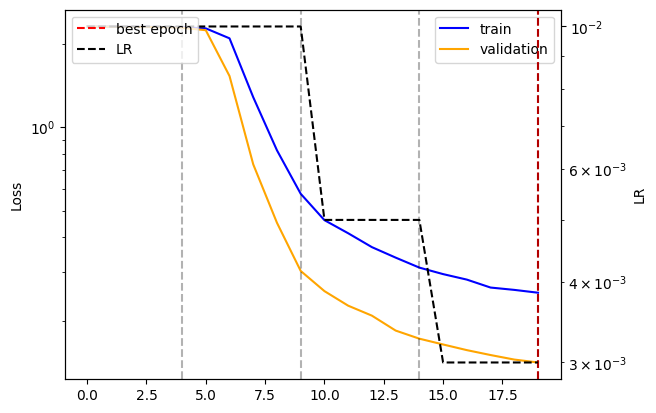

In [21]:
if TRAIN:
  f,ax = plt.subplots(1,1)
  ax2 = ax.twinx()
  ax.plot(train_curve,label="train",color="blue")
  ax.plot(val_curve,label="validation",color="orange")
  ax2.axvline(best_epoch,color="r",linestyle="--",label="best epoch")
  for e in epc_ckp:
    ax2.axvline(e-1,color="k",linestyle="--",alpha=0.3)
  ax.legend(loc=1)
  ax.set_ylabel("Loss")


  ax2.plot(lr_curve,"k--",label="LR",)
  ax2.legend(loc=2)
  plt.xlabel("Epochs")
  ax2.set_ylabel("LR")
  ax2.set_yscale("log")
  ax.set_yscale("log")

In [22]:
model = Net()
model.load_state_dict(torch.load('results/best_weights.pth'))
model.to("cpu")
model.eval()

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=576, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)

In [23]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

def test_model(model, test_loader):
    model.eval()

    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, targets in test_loader:

            outputs = model(inputs)
            targets = targets.numpy()
            outputs = outputs.numpy()

            predicted = np.argmax(outputs, 1)
            #targets = np.argmax(targets , 1)

            y_true.extend(targets)
            y_pred.extend(predicted)

    cm = confusion_matrix(y_true, y_pred,normalize="true")

    return np.array(y_true), np.array(y_pred), cm

In [24]:
_,_,cm=test_model(model, testloader)

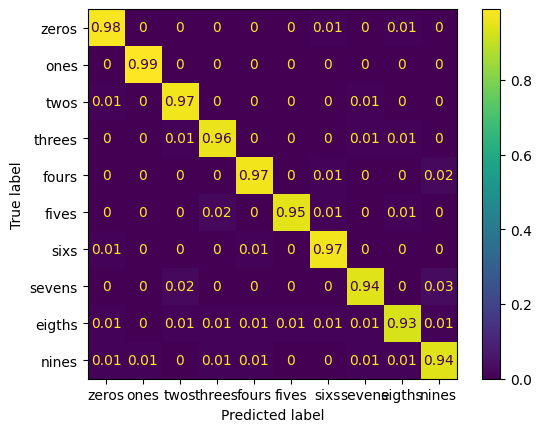

In [25]:
disp = ConfusionMatrixDisplay(confusion_matrix=np.round(cm,2),
                              display_labels=["zeros","ones", "twos", "threes", "fours","fives","sixs","sevens","eigths","nines"])
disp.plot()

plt.show()

In [26]:
def compute_integrated_gradient(batch_x, batch_blank, c, model,MODE= "pred",sel=3):
    mean_grad = 0
    n = 32


    for i in range(1, n + 1):
        x = batch_blank + i / n * (batch_x - batch_blank)
        x.requires_grad = True
        y = model(x).squeeze()
        if MODE == "pred":
          c = torch.argmax(y)
          y = y[c]
        if MODE == "sum":
          c = torch.argmax(y)
          y = y.sum()
        if MODE == "sel":
          c = torch.argmax(y)
          y = y[sel]

        #print(y.shape)
        (grad,) = torch.autograd.grad(y, x,is_grads_batched=False)
        mean_grad += grad / n

    integrated_gradients = (batch_x - batch_blank) * mean_grad
    integrated_gradients=integrated_gradients.detach().numpy()
    integrated_gradients = integrated_gradients / np.absolute(integrated_gradients).max()

    return integrated_gradients,c.detach().numpy().squeeze()

In [27]:
def get_IGs(test_dataset):
  IGs = []
  preds = []

  for i, (r,c) in enumerate(test_dataset):
    batch_x = r.unsqueeze(0)
    batch_blank = torch.zeros_like(batch_x)

    IG,pred = compute_integrated_gradient(batch_x, batch_blank, c, model,MODE="sel")

    IGs.append(IG.squeeze())
    preds.append(pred)

    if i > 127:
      break
  return(IGs,preds)



In [28]:
def plot_IG(trainset,IGs,preds,to_plot):
  image = trainset[to_plot][0][0].detach().cpu().numpy()
  lab = trainset[to_plot][1]
  IG, pred =  IGs[to_plot],preds[to_plot]
  f,ax = plt.subplots(1,2,figsize=(8,5))
  ax[0].matshow(image,cmap="Greys")
  ax[0].set_title(" class {}".format(lab),fontsize=30)
  ax[1].matshow(IG,cmap="seismic",vmin=-1,vmax=1)
  ax[1].set_title("IG ",fontsize=30)


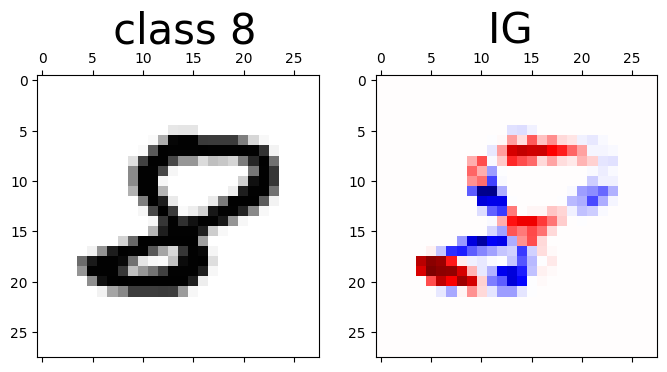

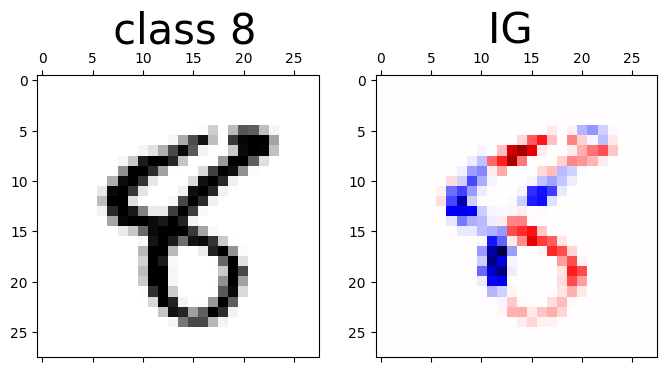

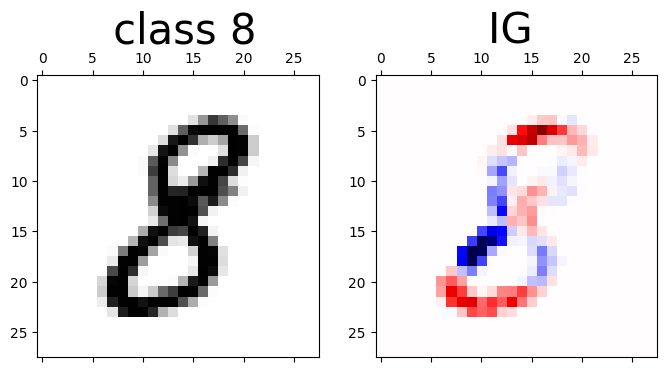

In [29]:
if 1:
  IGs,preds = get_IGs(testset)
  for to_plot in range(128):
    if preds[to_plot]==8:
      plot_IG(testset,IGs,preds, to_plot)

In [30]:
im,lab = testset[2]
print(im.shape)
print(lab)

torch.Size([1, 28, 28])
1


In [31]:
def get_gradients(x,lab, model,device="cpu"):
  #  function that takes a model and a element and returns gradient for that point
  lab=torch.Tensor([lab]).long()
  model.eval()
  loss=0.0
  y = model(x)
  L = criterion(y, lab)
  params = [p for p in model.parameters() if p.requires_grad]
  grads = torch.autograd.grad(L, params )
  return list(grads)

def grad_dot_prod(grad_z0,grad_z1):
  #scalar product for all the gradients (iterated over the list)
    return sum([torch.sum(k*j).data for k,j in zip(grad_z0,grad_z1)]).cpu().numpy()


In [32]:
grads = get_gradients(im.unsqueeze(0),lab,model)
print(grads[0].shape) # this is the fist conv layer 16 kernels with 3x3 kernel size

torch.Size([32, 1, 3, 3])


In [33]:
dotp = grad_dot_prod(grads,grads)# test the function
print("this is the gradients module : ", dotp)

this is the gradients module :  0.0046043606


In [34]:
lr_ckp

array([0.01 , 0.01 , 0.005, 0.003])

In [35]:
#list of chekpoints that we saved
ckp_list = []
for file in os.listdir("results/"):
    if file.startswith("ckp"):
        print("results/"+file)
        ckp_list.append("results/"+file)
ckp_list.sort()
assert len(lr_ckp  )==len(ckp_list)
print(ckp_list)

results/ckp_5.pth
results/ckp_10.pth
results/ckp_20.pth
results/ckp_15.pth
['results/ckp_10.pth', 'results/ckp_15.pth', 'results/ckp_20.pth', 'results/ckp_5.pth']


In [36]:
def load_model(ckp):
  # a function that load a model given a checkpoint path
  model=Net()
  model.load_state_dict(torch.load(ckp))
  model.eval()
  return model

In [37]:
def tracIn(dataset,z_test,ckp_list,lr_ckp):

  train_dataset_size = len(dataset)
  print("TracIn over dataset size : ",train_dataset_size)
  ckp_iter=0
  influences = np.zeros((train_dataset_size,len(ckp_list)))

  im_t,lab_t = z_test#test_dataset[2]

  for c, ckp in enumerate(ckp_list):
    print("checkpoint {}/{}".format(c,len(ckp_list)))
    model = load_model(ckp)# carico il checkpoint
    model.eval()
    lr=lr_ckp[c]
    grads_test = get_gradients(im_t.unsqueeze(0),lab_t,model)

    for i in range(train_dataset_size):
        if (i%100 == 0):
          print("example {}/{}".format(i,train_dataset_size))
        im,lab = dataset[i]#test_dataset[2]
        grads_train = get_gradients(im.unsqueeze(0),lab,model)
        dotp = grad_dot_prod(grads_test,grads_train)
        influences[i,c] = dotp*lr

  influences_t = np.sum(influences,axis=1)
  opponents = np.argsort(influences_t)
  proponents = opponents[::-1]

  return influences, proponents, opponents



In [38]:
#cut the dataset so we are faster
import torch.utils.data as data_utils

indices = torch.randint(len(trainset), (2500,))
tr_small = data_utils.Subset(trainset, indices)

In [39]:
influences, proponents, opponents = tracIn(tr_small,testset[2],ckp_list,lr_ckp)
print(influences.shape)

TracIn over dataset size :  2500
checkpoint 0/4
example 0/2500
example 100/2500
example 200/2500
example 300/2500
example 400/2500
example 500/2500
example 600/2500
example 700/2500
example 800/2500
example 900/2500
example 1000/2500
example 1100/2500
example 1200/2500
example 1300/2500
example 1400/2500
example 1500/2500
example 1600/2500
example 1700/2500
example 1800/2500
example 1900/2500
example 2000/2500
example 2100/2500
example 2200/2500
example 2300/2500
example 2400/2500
checkpoint 1/4
example 0/2500
example 100/2500
example 200/2500
example 300/2500
example 400/2500
example 500/2500
example 600/2500
example 700/2500
example 800/2500
example 900/2500
example 1000/2500
example 1100/2500
example 1200/2500
example 1300/2500
example 1400/2500
example 1500/2500
example 1600/2500
example 1700/2500
example 1800/2500
example 1900/2500
example 2000/2500
example 2100/2500
example 2200/2500
example 2300/2500
example 2400/2500
checkpoint 2/4
example 0/2500
example 100/2500
example 200/25

In [40]:
proponents

array([2078, 1292, 1002, ..., 2020,  318, 1989])

Text(0.5, 0, 'influence score')

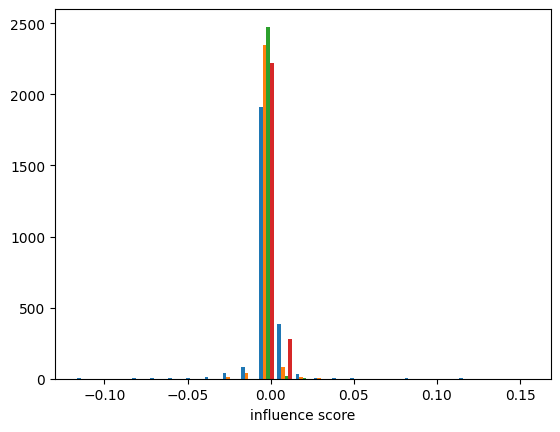

In [41]:
plt.figure()
_,_,_ = plt.hist(influences,25)
plt.xlabel("influence score")

In [42]:
#proponents

In [43]:
def plot_proponents(dat,train_datatset):
  _, proponents, opponents = tracIn(train_datatset,dat,ckp_list,lr_ckp)
  image,lab = dat
  image_p, lab_p = train_datatset[proponents[1]]
  image_o, lab_o = train_datatset[opponents[1]]
  image,lab = image.numpy().squeeze(),lab
  image_p,lab_p = image_p.numpy().squeeze(),lab_p
  image_o,lab_o = image_o.numpy().squeeze(),lab_o
  f,ax = plt.subplots(1,3,figsize=(12,5))
  ax[0].matshow(image,cmap="Greys")
  ax[0].set_title(" class {}".format((lab)),fontsize=20)
  ax[1].matshow(image_p,cmap="Greys")
  ax[1].set_title(" Proponent class {}".format((lab_p)),fontsize=20)
  ax[2].matshow(image_o,cmap="Greys")
  ax[2].set_title(" Opponent class {}".format((lab_o)),fontsize=20)


TracIn over dataset size :  2500
checkpoint 0/4
example 0/2500
example 100/2500
example 200/2500
example 300/2500
example 400/2500
example 500/2500
example 600/2500
example 700/2500
example 800/2500
example 900/2500
example 1000/2500
example 1100/2500
example 1200/2500
example 1300/2500
example 1400/2500
example 1500/2500
example 1600/2500
example 1700/2500
example 1800/2500
example 1900/2500
example 2000/2500
example 2100/2500
example 2200/2500
example 2300/2500
example 2400/2500
checkpoint 1/4
example 0/2500
example 100/2500
example 200/2500
example 300/2500
example 400/2500
example 500/2500
example 600/2500
example 700/2500
example 800/2500
example 900/2500
example 1000/2500
example 1100/2500
example 1200/2500
example 1300/2500
example 1400/2500
example 1500/2500
example 1600/2500
example 1700/2500
example 1800/2500
example 1900/2500
example 2000/2500
example 2100/2500
example 2200/2500
example 2300/2500
example 2400/2500
checkpoint 2/4
example 0/2500
example 100/2500
example 200/25

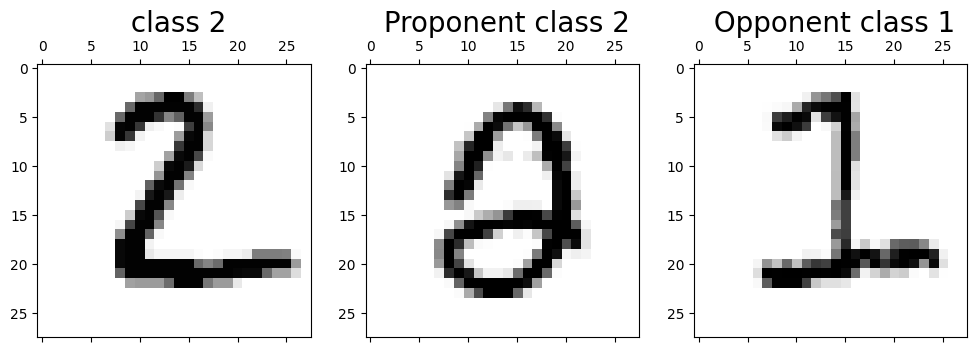

In [44]:
plot_proponents(testset[1], tr_small)

In [45]:
len(testset)


indices = torch.where((trainset.dataset.targets == 7))[0] # if you want to keep images with the label 4
indices = indices[indices<len(trainset)]
print("4 in train : ",len(indices))
indices = indices[torch.randint(len(indices), (256,))]# take 128 at random
tr_small  = data_utils.Subset(train, indices)



print("4 dataset reduced : ",len(tr_small))
for k in range(10):
  print(tr_small[k][1])

4 in train :  5175
4 dataset reduced :  256
7
7
7
7
7
7
7
7
7
7


In [46]:
T_INFLUENCE_MATRIX = np.zeros((len(tr_small),len(tr_small),len(ckp_list)))
for k in range(len(tr_small)):
  if k % 25==0:
    print("test example {}/{}".format(k,len(tr_small)))
  influences, _, _ = tracIn(tr_small,tr_small[k],ckp_list,lr_ckp)
  T_INFLUENCE_MATRIX[k,:,:] = influences

test example 0/256
TracIn over dataset size :  256
checkpoint 0/4
example 0/256
example 100/256
example 200/256
checkpoint 1/4
example 0/256
example 100/256
example 200/256
checkpoint 2/4
example 0/256
example 100/256
example 200/256
checkpoint 3/4
example 0/256
example 100/256
example 200/256
TracIn over dataset size :  256
checkpoint 0/4
example 0/256
example 100/256
example 200/256
checkpoint 1/4
example 0/256
example 100/256
example 200/256
checkpoint 2/4
example 0/256
example 100/256
example 200/256
checkpoint 3/4
example 0/256
example 100/256
example 200/256
TracIn over dataset size :  256
checkpoint 0/4
example 0/256
example 100/256
example 200/256
checkpoint 1/4
example 0/256
example 100/256
example 200/256
checkpoint 2/4
example 0/256
example 100/256
example 200/256
checkpoint 3/4
example 0/256
example 100/256
example 200/256
TracIn over dataset size :  256
checkpoint 0/4
example 0/256
example 100/256
example 200/256
checkpoint 1/4
example 0/256
example 100/256
example 200/256

In [47]:
# diagonal set to 1

def diag2one(T_INFLUENCE_MATRIX) :
  norm_matrix = np.zeros(T_INFLUENCE_MATRIX.shape)
  for c in range(T_INFLUENCE_MATRIX.shape[-1]):
    norm_matrix[:,:,c] = T_INFLUENCE_MATRIX[:,:,c] / np.diag(T_INFLUENCE_MATRIX[:,:,c])
    return  norm_matrix


In [49]:
T_INFLUENCE_MATRIX_cut = T_INFLUENCE_MATRIX
if 0:
  norm_matrix = diag2one(T_INFLUENCE_MATRIX_cut)
else:
  norm_matrix  = T_INFLUENCE_MATRIX_cut

if 0:
  for c in range(T_INFLUENCE_MATRIX_cut.shape[-1]):
    norm_matrix[:,:,c] = norm_matrix[:,:,c] - np.median(norm_matrix[:,:,c],axis=1)

#norm_matrix = norm_matrix - np.diag(norm_matrix)#
# remove self
if 0:
  for i in range(norm_matrix.shape[0]):
    norm_matrix[i,i,:] = norm_matrix[:,i,:].mean(axis=0)

from sklearn.preprocessing import StandardScaler
norm_matrix = norm_matrix.reshape(norm_matrix.shape[0],-1)
norm_matrix = StandardScaler().fit_transform(norm_matrix)

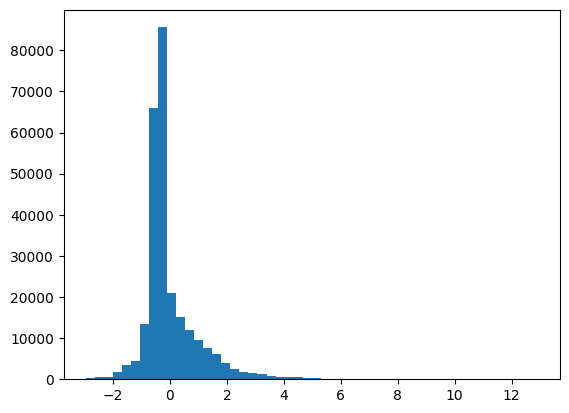

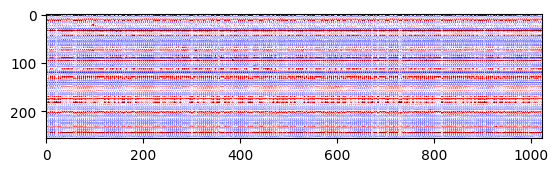

In [50]:
plt.figure()
plt.hist(norm_matrix.flatten(),50)
plt.figure()
plt.imshow(norm_matrix, cmap="seismic",vmin=-2, vmax=2)

In [51]:
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap
#pca = PCA(n_components=10)
#reduced = pca.fit_transform(norm_matrix)
embedding = Isomap(n_components=2)
reduced = embedding.fit_transform(norm_matrix)
#print(pca.explained_variance_ratio_)

In [52]:
from sklearn.cluster import Birch
kmeans = Birch(n_clusters=10).fit(norm_matrix)

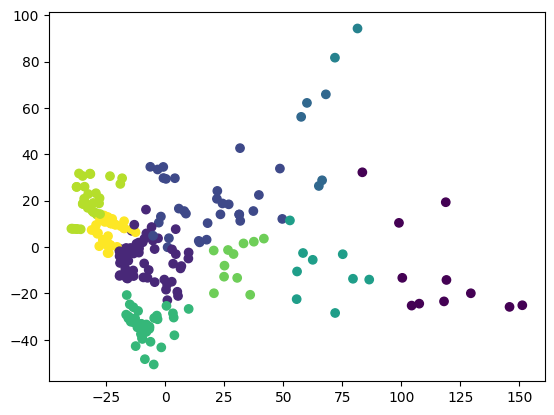

In [53]:
plt.scatter(reduced[:,0],reduced[:,1],c=kmeans.labels_)

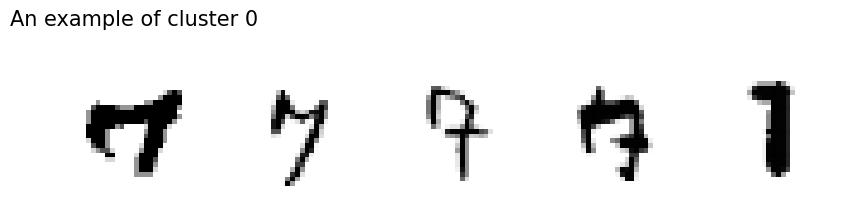

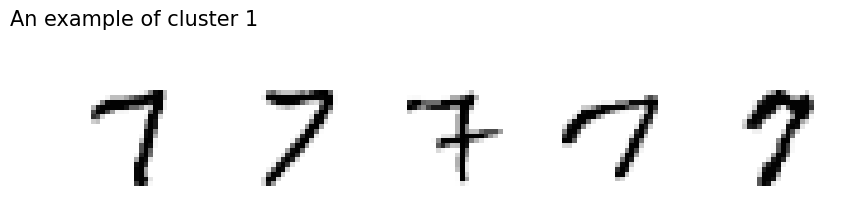

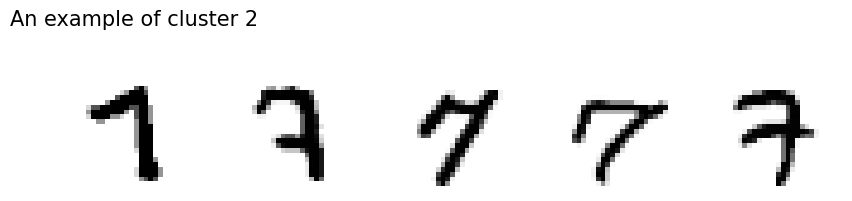

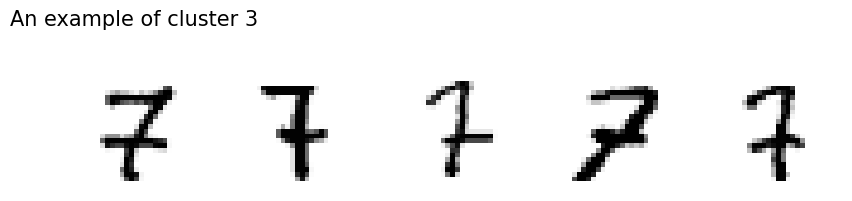

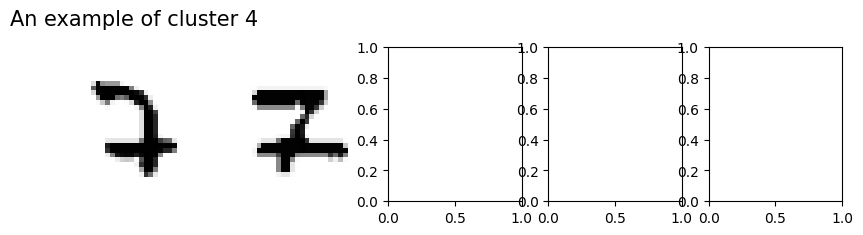

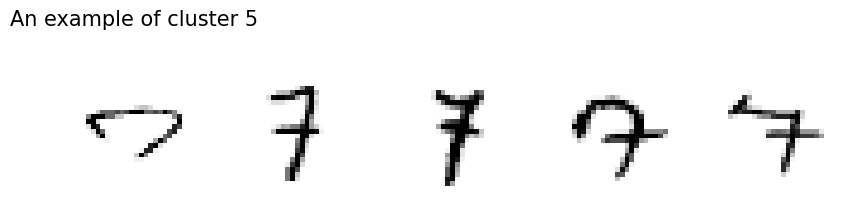

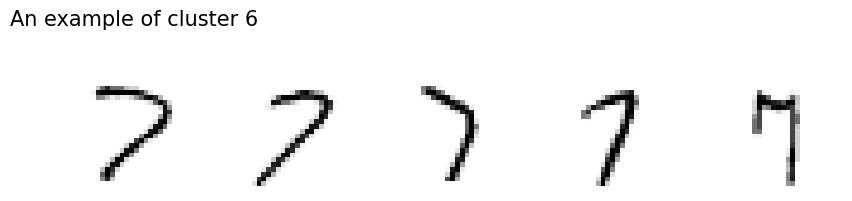

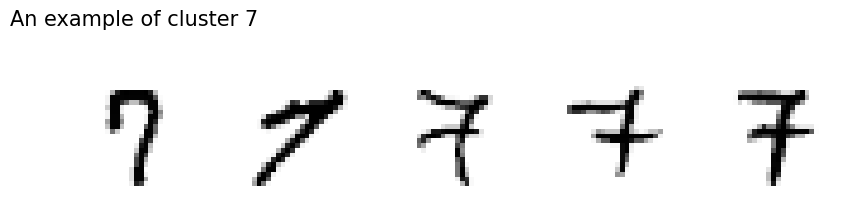

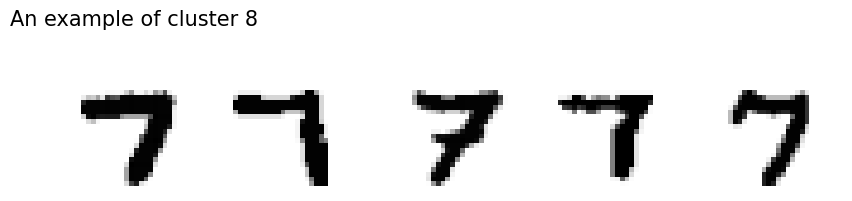

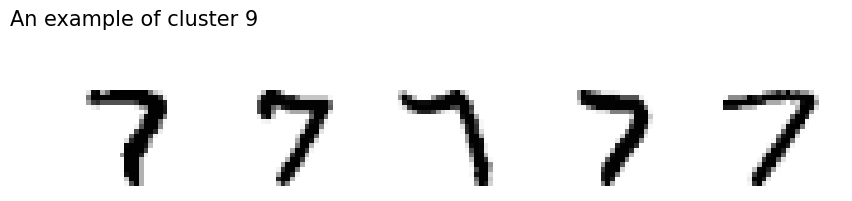

In [54]:
clusters = np.unique(kmeans.labels_)
for c in clusters:
  size_c = (kmeans.labels_ == c).sum()
  n_show = 5 if size_c> 5 else  size_c
  #print(size_c)
  #print(n_show)
  belongToC = np.where(kmeans.labels_ == c)[0][0:n_show]
  #print(belongToC)
  f,axes = plt.subplots(1,5, figsize=(10,2))
  for i,ax in enumerate(axes):

    if i >= size_c:
      break
    to_plot = belongToC[i]
    image = tr_small[to_plot][0][0].detach().cpu().numpy()
    lab = tr_small[to_plot][1]

    ax.matshow(image,cmap="Greys")
    ax.axis('off')
    if i==0:
      ax.set_title("An example of cluster {}".format(c),fontsize=15)